# plotting custom subcortical atlas

this notebook demonstrates how to convert a custom nifti subcortical atlas (in this case the [tian subcortical atlas 2020](https://github.com/yetianmed/subcortex)) into the gifti surface format required for `yabplot`.

**why convert?**
yabplot visualizes subcortical structures as 3d meshes (surfaces), but most mri atlases come as 3d volumes (voxels). we need to extract these surfaces to plot them.

**input:**
- `.nii.gz` volumetric atlas.
- `.txt` label file (region names).

**output:**
- folder of `.gii` files (one per region) ready for the `custom_atlas_path` parameter.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pooch
from skimage import measure
import yabplot as yab

# 1. setup paths
# we will download the atlas to a temporary folder for this tutorial
work_dir = "tutorial_data/tian_atlas"
os.makedirs(work_dir, exist_ok=True)

print("downloading atlas files...")
atlas_path = pooch.retrieve(
    url="https://github.com/yetianmed/subcortex/raw/master/Group-Parcellation/3T/Subcortex-Only/Tian_Subcortex_S1_3T_1mm.nii.gz",
    known_hash=None,
    path=work_dir,
    fname="tian_s1_3t.nii.gz",
)

label_path = pooch.retrieve(
    url="https://raw.githubusercontent.com/yetianmed/subcortex/master/Group-Parcellation/3T/Subcortex-Only/Tian_Subcortex_S1_3T_label.txt",
    known_hash=None,
    path=work_dir,
    fname="tian_s1_3t_label.txt",
)

# define where our converted surfaces will go
output_dir = os.path.join(work_dir, "surfaces")
os.makedirs(output_dir, exist_ok=True)

downloading atlas files...


SHA256 hash of downloaded file: cac4fe559304ce97c5e6905c33e7eeff0139750a51dbfdbd1b933c5f6ba10c42
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: f8dc7acae3483952d41d49b9145b4d13c5bc28da1c410114a561a5efda55db8c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


## step 1: inspect input data

before processing, it is good to verify what we downloaded. 

first, let's look at the directory structure to understand what files we are working with.

In [72]:
def print_file_tree(startpath):
    """simple helper to print directory structure."""
    print(f"+ {os.path.basename(startpath)}/")
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level + 1)
        subindent = ' ' * 4 * (level + 2)
        print(f"{indent}+ {os.path.basename(root)}/")
        for f in sorted(files):
            if not f.startswith('.'): # ignore hidden files
                print(f"{subindent}- {f}")

print("current project structure:")
print_file_tree(work_dir)

current project structure:
+ tian_atlas/
    + tian_atlas/
        - tian_s1_3t.nii.gz
        - tian_s1_3t_label.txt
        + surfaces/


## step 2: parse the label file

we need to map the integer ids seen in the plot above to actual region names.
the tian atlas label file is a simple list of names. we assume line 1 maps to id 1.

we also standardize the names (e.g., "-rh" to "_R") so `yabplot` can automatically detect the hemisphere.

In [73]:
print("parsing labels...")
rois = {}

with open(label_path, 'r') as f:
    # use enumerate starting at 1 to generate ids matching the nifti mask
    for idx, line in enumerate(f, start=1):
        name = line.strip()
        if name:
            # cleanup name: replace hyphens/spaces with underscores for safe filenames
            clean_name = name.replace(' ', '_')
            
            # yabplot expects names like "Left_Thalamus" or "Thalamus_L" 
            # for auto-side detection.
            # the tian atlas uses "-rh" and "-lh". we standardize this to "_R" and "_L".
            if clean_name.endswith('-rh') or clean_name.endswith('_rh'):
                clean_name = clean_name.replace('-rh', '_R').replace('_rh', '_R')
            elif clean_name.endswith('-lh') or clean_name.endswith('_lh'):
                clean_name = clean_name.replace('-lh', '_L').replace('_lh', '_L')
                
            rois[idx] = clean_name

print(f"parsed {len(rois)} regions.")
print(f"example: id 1 maps to '{rois[1]}'")

parsing labels...
parsed 16 regions.
example: id 1 maps to 'HIP_R'


## step 3: convert volumes to surfaces

we loop through each ROI, isolate it using a binary mask, run marching cubes to generate a mesh, and save it as a gifti (`.gii`) file.

In [74]:
# load the volumetric atlas
img = nib.load(atlas_path)
data = img.get_fdata()
affine = img.affine

print(f"processing {len(rois)} regions from nifti volume...")

for roi_id, name in rois.items():
    # 1. create binary mask for this region
    mask = (data == roi_id).astype(np.uint8)
    
    # skip empty regions if any exist
    if np.sum(mask) == 0:
        print(f"skipping {name} (id {roi_id}): no voxels found.")
        continue

    # 2. marching cubes
    # extracts the surface mesh from the 3d mask.
    verts, faces, normals, values = measure.marching_cubes(mask, level=0.5)
    
    # 3. apply affine transform
    # marching_cubes returns voxel indices. apply affine to get mni coordinates.
    verts_mni = nib.affines.apply_affine(affine, verts)
    
    # 4. create gifti image
    # yabplot expects standard nifti intent codes for points and triangles
    coord_array = nib.gifti.GiftiDataArray(
        data=verts_mni.astype(np.float32), 
        intent='NIFTI_INTENT_POINTSET'
    )
    face_array = nib.gifti.GiftiDataArray(
        data=faces.astype(np.int32), 
        intent='NIFTI_INTENT_TRIANGLE'
    )
    gii = nib.gifti.GiftiImage(darrays=[coord_array, face_array])
    
    # 5. save
    out_name = os.path.join(output_dir, f"{name}.surf.gii")
    nib.save(gii, out_name)

print("conversion complete!")

processing 16 regions from nifti volume...
conversion complete!


## step 4: verify the custom atlas structure

now that conversion is done, let's look at our folder structure again. `yabplot` expects a folder full of mesh files.

In [75]:
print("final custom atlas structure:")
print_file_tree(output_dir)

final custom atlas structure:
+ surfaces/
    + surfaces/
        - AMY_L.surf.gii
        - AMY_R.surf.gii
        - CAU_L.surf.gii
        - CAU_R.surf.gii
        - GP_L.surf.gii
        - GP_R.surf.gii
        - HIP_L.surf.gii
        - HIP_R.surf.gii
        - NAc_L.surf.gii
        - NAc_R.surf.gii
        - PUT_L.surf.gii
        - PUT_R.surf.gii
        - aTHA_L.surf.gii
        - aTHA_R.surf.gii
        - pTHA_L.surf.gii
        - pTHA_R.surf.gii


## step 5: visualize with yabplot

we can now pass this folder path directly to `custom_atlas_path`.

note: the first time you run this, `yabplot` will automatically smooth these "jagged" voxel-derived meshes and cache them as `.vtk` files in the same folder.

found 16 regions in custom folder: ['AMY_L', 'AMY_R', 'CAU_L']...


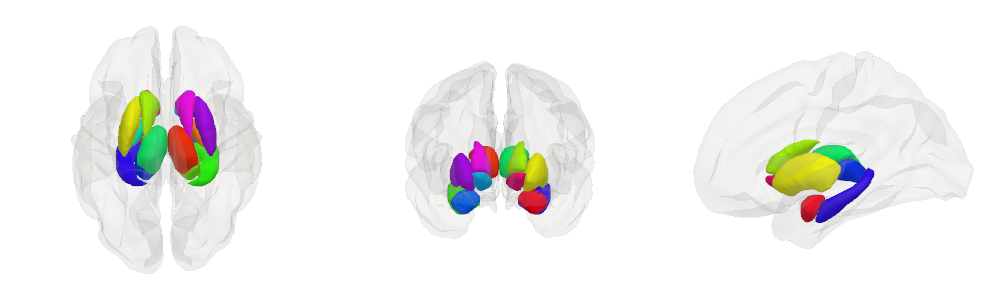

In [76]:
# 1. verify regions were found
regions = yab.get_atlas_regions(
    atlas=None, 
    category='subcortical', 
    custom_atlas_path=output_dir
)
print(f"found {len(regions)} regions in custom folder: {regions[:3]}...")

# 2. plot the atlas (structure only)
yab.plot_subcortical(
    custom_atlas_path=output_dir,
    figsize=(1000, 300),
    views=['superior', 'anterior', 'left_lateral'],
    # we can tune smoothing for these specific meshes
    custom_atlas_proc={'smooth_i': 20, 'smooth_f': 0.5},
    style='sculpted',
    display_type='static'
)

## step 6: plot with data

now we can map data to our new custom atlas just like any standard one.

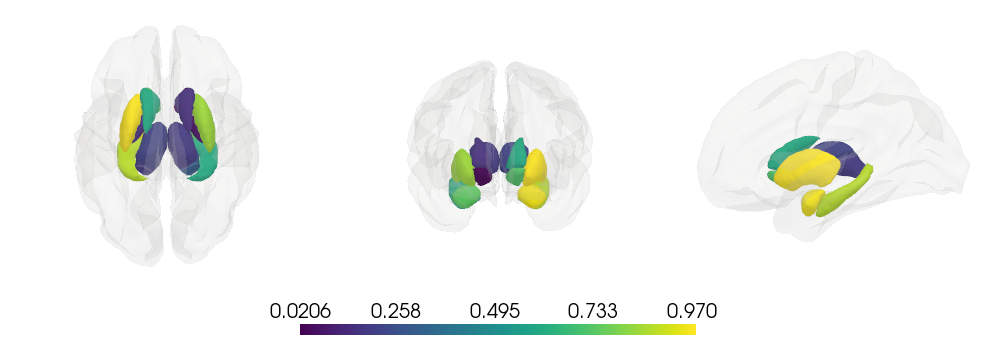

In [77]:
# create dummy data matching the region count
data = np.random.rand(len(regions))

yab.plot_subcortical(
    data=data,
    custom_atlas_path=output_dir,
    figsize=(1000, 350),
    cmap='viridis',
    views=['superior', 'anterior', 'left_lateral'],
    style='default',
    display_type='static'
)

## extra: using custom atlases for white matter tracts

while this tutorial focused on converting and visualizing **subcortical** volumes, `yabplot` supports custom atlases for white matter tracts as well.

this works exactly like the subcortical example above. you simply point `custom_atlas_path` to a folder, and `yabplot` will visualize every tract file it finds there.

* **requirement:** a directory containing `.trk` or `.tck` files.
* **naming:** the filename determines the region name (e.g., `CST_Left.trk` becomes `'CST_Left'`).
* **alignment:** ensure your tract files are in the same space as the background brain (standard MNI152 by default) so they align correctly.